# Sample Random Graphs and Datasets

We will generate mixed discrete-continuous and nonlinear observational data based upon the mixed additive noise model (MANM). This will be based on the [MANM python package](https://github.com/hpi-epic/manm-cs).

NOTE: for now, we are only simulating causal DAGs, not ADMGs.

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path
from pprint import pprint
import json

import numpy as np
import bnlearn as bn
import networkx as nx

import causal_networkx
from causal_networkx.ci import (
    GSquareCITest,
    FisherZCITest,
    Oracle,
    ParentChildOracle,
)
from causal_networkx.discovery import PC, RobustPC
from causal_networkx.io import load_from_pgmpy
from causal_networkx.simulation.random import simulate_random_graphs_manm_cs
from causal_networkx.io import read_dot, load_from_networkx

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
np.random.seed(12345)

In [5]:
import graphviz

# Simulate One Graph

In [5]:
n_nodes = 5
edge_density = 0.3
n_samples = 1000
graph, df, builder = simulate_random_graphs_manm_cs(
    n_nodes=n_nodes,
    edge_density=edge_density,
    n_samples=n_samples,
)

(1000, 5)


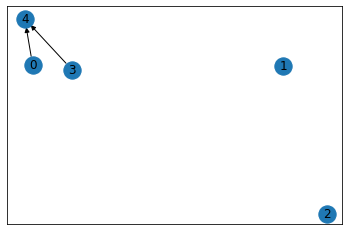

In [6]:
print(graph)
graph.draw()
print(df.shape)

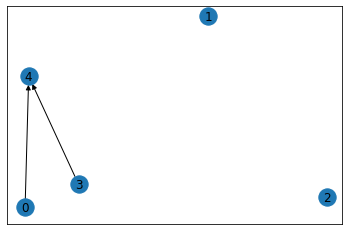

In [44]:
fname = "/Users/adam2392/Downloads/test.gml"

graph.save(fname, format="networkx-gml")

read_graph = nx.read_gml(fname)
test_graph = load_from_networkx(read_graph)

test_graph.draw()

# Simulate Now Many Graphs and Save to Dataset

Each graph is defined by a set of parameters in the MANM module:

- number of nodes
- edge density (0 to 1)
- discrete node ratio
- discrete SNR
- number of discrete classes
- continuous noise std
- function type ([linear, quadratic, cubic, tanh, sin, cos])

In [11]:
n_samples = 500000
discrete_node_ratio = 0.0
idx = -1

output_dir = Path("/Volumes/Extreme Pro/structure_learning_manm_sim/")
output_dir.mkdir(exist_ok=True, parents=True)

# TODO: see if literature has hints on setting alpha
# todo: causal structure learning for correcting for pvalues
# during local learning i.e. X \perp Y | Z
#
# IDEAS:
# - correction based on statistical information aka FDR/Bonf
# - correction based on some non-causal structure aka adjacency paths
#
# discrete_node_ratio is 0 -> maybe use partial corr, or KCI if insufficient
# start with functions = linear
# alpha = # iterate over various numbers

# reached 249 idx in lab june 7th 4:50PM
for n_nodes in range(5, 15):
    for edge_density in np.linspace(0.1, 0.9, 9):
        for continuous_noise_std in np.linspace(0.1, 3.0, 10):
            idx += 1
            if idx <= 249:
                continue

            graph, df, builder = simulate_random_graphs_manm_cs(
                n_nodes=n_nodes,
                edge_density=edge_density,
                n_samples=n_samples,
                discrete_node_ratio=discrete_node_ratio,
                continuous_noise_std=continuous_noise_std,
            )
            fname = output_dir / f"graph_{idx}.gml"
            json_fname = output_dir / f"graph_{idx}.json"
            df_fname = output_dir / f"graph_{idx}.csv"

            # save the dataset
            df.to_csv(df_fname)

            # save the graph and the metadataset
            json_dict = {
                "idx": idx,
                "n_nodes": builder.num_nodes,
                "n_samples": n_samples,
                "edge_density": builder.edge_density,
                "discrete_node_ratio": builder.discrete_node_ratio,
                "conditional_gaussian": builder.conditional_gaussian,
                "discrete_signal_to_noise_ratio": builder.discrete_signal_to_noise_ratio,
                "min_discrete_value_classes": builder.min_discrete_value_classes,
                "max_discrete_value_classes": builder.max_discrete_value_classes,
                "continuous_noise_std": builder.continuous_noise_std,
                "beta_lower_limit": builder.beta_lower_limit,
                "beta_upper_limit": builder.beta_upper_limit,
                "functions_prob": [p[0] for p in builder.functions],
                "functions": "linear",
            }

            graph.save(fname, format="networkx-gml")
            with open(json_fname, "w") as fout:
                json.dump(json_dict, fout)

            # idx += 1

In [13]:
print(idx)

899


# Simulate Large Graphs With Long Chains

Simulate large graphs with possibility for long chains that induce statistical unfaithfulness due to weak effects over long chains.

In [21]:
n_nodes = 20
edge_density = 0.08
n_samples = 1000
seed = 12345
graph, df, builder = simulate_random_graphs_manm_cs(
    n_nodes=n_nodes, edge_density=edge_density, n_samples=n_samples, seed=seed
)

In [22]:
graph.add_edge(16, 17)
graph.add_chain([15, "a", "b", "c", "d"])
graph.add_edge(19, "b")

DAG with 24 nodes, 26 edges
(1000, 20)


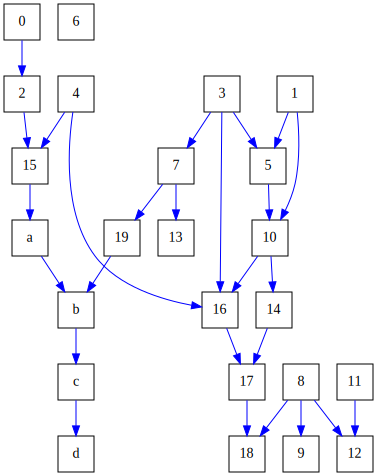

In [23]:
print(graph)
print(df.shape)
graph.draw()

In [24]:
print(graph.nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 'a', 'b', 'c', 'd']


In [25]:
fname = "/Users/adam2392/Downloads/test.gml"
graph.save(fname=fname, format="networkx-gml")

In [17]:
nx.write_gml(graph.to_networkx(), fname)

In [18]:
graph = nx.read_gml(fname)

NetworkXError: node label '16' is duplicated

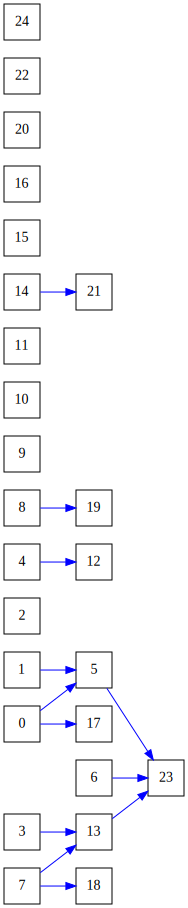

In [57]:
graph.draw(direction="LR")

In [52]:
n_samples = 500000
discrete_node_ratio = 0.0
idx = -1
n_nodes = 25
edge_density = 0.1
seed = 12345

for continuous_noise_std in np.linspace(0.1, 3.0, 10):
    idx += 1

    output_dir = Path("/Volumes/Extreme Pro/structure_learning_manm_sim/long_chains/")
    output_dir.mkdir(exist_ok=True, parents=True)
    graph, df, builder = simulate_random_graphs_manm_cs(
        n_nodes=n_nodes,
        edge_density=edge_density,
        n_samples=n_samples,
        discrete_node_ratio=discrete_node_ratio,
        continuous_noise_std=continuous_noise_std,
        seed=seed,
    )
    fname = output_dir / f"graph_{idx}.gml"
    json_fname = output_dir / f"graph_{idx}.json"
    df_fname = output_dir / f"graph_{idx}.csv"

    # save the dataset
    df.to_csv(df_fname)

    # save the graph and the metadataset
    json_dict = {
        "idx": idx,
        "n_nodes": builder.num_nodes,
        "n_samples": n_samples,
        "edge_density": builder.edge_density,
        "discrete_node_ratio": builder.discrete_node_ratio,
        "conditional_gaussian": builder.conditional_gaussian,
        "discrete_signal_to_noise_ratio": builder.discrete_signal_to_noise_ratio,
        "min_discrete_value_classes": builder.min_discrete_value_classes,
        "max_discrete_value_classes": builder.max_discrete_value_classes,
        "continuous_noise_std": builder.continuous_noise_std,
        "beta_lower_limit": builder.beta_lower_limit,
        "beta_upper_limit": builder.beta_upper_limit,
        "functions_prob": [p[0] for p in builder.functions],
        "functions": "linear",
    }

    graph.save(fname, format="networkx-gml")
    with open(json_fname, "w") as fout:
        json.dump(json_dict, fout)

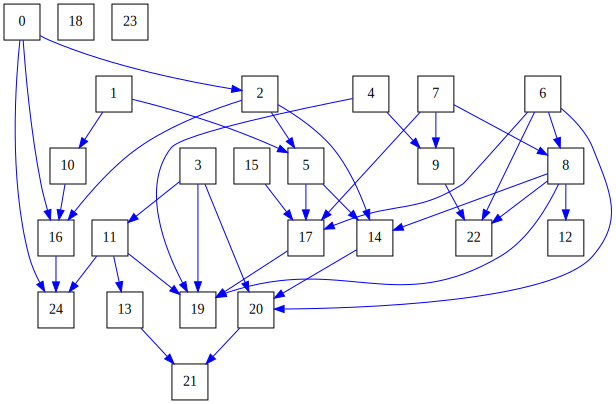

In [53]:
graph.draw()